This notebook contains preprocessing steps as well as scripts for an EDA on label and token distributions.

In [14]:
import yaml
from transformers import AutoTokenizer
from datasets import load_dataset
from collections import Counter
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

In [15]:
# Reading config file
config = yaml.safe_load(open("../settings/config.yml"))

In [16]:
# Loading tokenizer
tokenizer = AutoTokenizer.from_pretrained(config['model_name'])

In [17]:
# Print maximum token length for the selected model
max_length = tokenizer.model_max_length
print("Maximum token length:", max_length)

Maximum token length: 512


In [18]:
LANGUAGE_INDEX = 0
LANGUAGE = config['languages_list'][LANGUAGE_INDEX]

# LOAD DATASET
data = load_dataset(config['dataset'], LANGUAGE)
data

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 4462
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 638
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1274
    })
})

In [19]:
LANGUAGE  # Selected language - "Bambara"

'bam'

### EDA on label distribution

Let's check label distribution for train / test / validation data:

In [20]:
def count_labels_in_masakhaner(tags, label_mapping):
    """
    Counts labels in dataset and replaces labels indexes with label names
    
    :param tags: list[list] where each sublist contains labels per record
    :param label_mapping: dict of the format {label: number of occurrences}
    :return: Counter object
    """
    labels_ = []
    # Iterate over each sentence 
    for sentence in tags:
        # Iterate over each label index in the sentence
        for label_idx in sentence:
            # Map the idx to its label and add to the list
            labels_.append(label_mapping[label_idx])
            
    # Use Counter to count the occurrences of each label
    label_counts = Counter(labels_)
    return label_counts


count_labels_in_masakhaner(tags=data['train']['ner_tags'], label_mapping=config['label_mapping'])

Counter({'O': 100325,
         'B-LOC': 1500,
         'I-PER': 1483,
         'B-PER': 1439,
         'I-DATE': 1274,
         'B-DATE': 530,
         'B-ORG': 217,
         'I-LOC': 174,
         'I-ORG': 56})

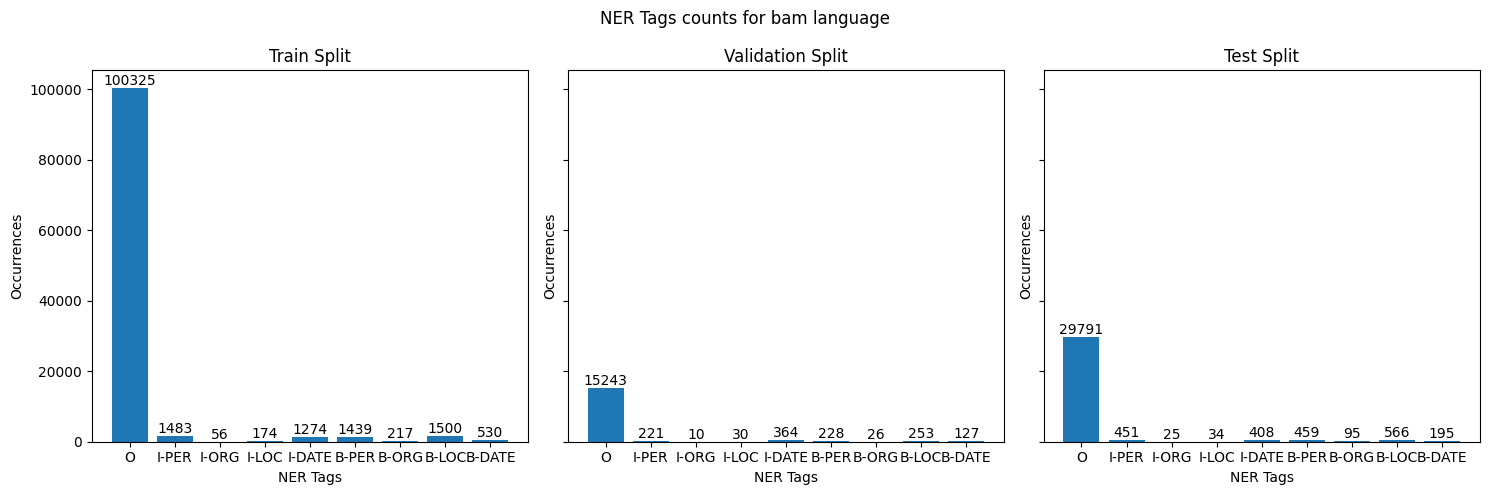

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, split in enumerate(['train', 'validation', 'test']):
    # Get NER tags counts for the current split
    ner_tags_counter = count_labels_in_masakhaner(data[split]['ner_tags'], config['label_mapping'])

    # Sort values by label names 
    labels, values = zip(*sorted(ner_tags_counter.items(), key=lambda x: x[0], reverse=True))
    
    axes[i].bar(labels, values)
    # Add numbers on top of each bar
    for label, value in zip(labels, values):
        axes[i].text(label, value, str(value), ha='center', va='bottom')
        
    axes[i].set_xlabel('NER Tags')
    axes[i].set_ylabel('Occurrences')
    axes[i].set_title(f'{split.capitalize()} Split')

plt.suptitle(f'NER Tags counts for {LANGUAGE} language')
plt.tight_layout()
plt.show()

### Aligning pre-trained tokenizer tokens with labels

Pre-trained tokenizer further splits tokens into sub-tokens according to its dictionary:

In [22]:
# "Abdrahamane Sissoko / Maliweb.net reports on the presidential election process, stating that 
# it will be transparent and fair, in February 2022, according to the expectations of the citizens."
test_tokens = [ "Abudarahamani", "Sisoko", "/", "Maliweb", ".", "net", "Kasɔrɔ", "perezidansigi", "kalafili", "ka", "kan", "ka", "kɛ", ",", "n'a", "bɔra", "a", "sira", "fɛ", ",", "feburuyekalo", "san", "2022", "la", ",", "mɔgɔba", "caman", "bisigilen", "don", "ka", "kɛ", "cɛbɔ", "ye", "." ]
test_labels = [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

tokenized_input = tokenizer(test_tokens, is_split_into_words=True)
tokenized_input

{'input_ids': [0, 62, 5331, 42528, 9051, 602, 7, 8795, 248, 22704, 14051, 6, 5, 2043, 4697, 184135, 42, 184135, 117, 10779, 549, 7, 8452, 5716, 67666, 156, 203, 156, 472, 171522, 6, 4, 653, 25, 11, 876, 184135, 219, 10, 99315, 1238, 171522, 6, 4, 3820, 25359, 1033, 51423, 3725, 72392, 21, 6, 4, 347, 184135, 177, 184135, 402, 377, 669, 2464, 872, 10739, 2301, 156, 472, 171522, 501, 171522, 275, 184135, 2422, 6, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [23]:
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
tokens[:10]

['<s>', '▁A', 'bud', 'araha', 'mani', '▁Si', 's', 'oko', '▁/', '▁Mali']

In [24]:
# word_ids() function is utilized to align labels
word_ids = tokenized_input.word_ids()
word_ids[:10]

[None, 0, 0, 0, 0, 1, 1, 1, 2, 3]

In [25]:
print(f'Random sentence from the dataset contains {len(test_tokens)} tokens, but number of tokens from pre-trained tokenizer is {len(tokens)}')

Random sentence from the dataset contains 34 tokens, but number of tokens from pre-trained tokenizer is 75


In [26]:
def align_labels(tokens, labels, tokenizer):
    """
    Aligns token labels with a tokenizer's output, considering subword tokenization.

    Args:
        tokens (List[str]): A list of word tokens that are not yet tokenized by the model's tokenizer.
        labels (List[int]): A list of integer labels corresponding to each token in `tokens`.
        tokenizer: The tokenizer that will be used to tokenize the `tokens`. This should be
                   a pre-initialized tokenizer from a Hugging Face's transformers library.
    Returns:
        Dict[str, List]: A dictionary with keys corresponding to tokenizer output (input_ids, attention_mask, etc.)
                         and a key 'labels' containing the aligned labels ready for model training.
    Raises:
        AssertionError: If the length of `tokens` and `labels` do not match.
    """
    # Ensure the tokens and labels lists are of the same length
    assert len(tokens) == len(labels), 'The length of tokens and labels must be the same.'

    # Create a mapping from token indices to their corresponding labels
    idx_to_label = {i: label for i, label in enumerate(labels)}

    # Special token ID that indicates a label to be ignored during loss computation.
    ignored_label_id = -100

    # Assign the ignore label ID to None to handle alignment of word-piece tokens to original tokens
    idx_to_label[None] = ignored_label_id

    # Tokenize the input tokens. `is_split_into_words=True` indicates that the input is pre-tokenized.
    tokenized_input = tokenizer(tokens, is_split_into_words=True)

    # Align the labels with the tokens using the 'word_ids' provided by the tokenizer
    tokenized_input['labels'] = [
        idx_to_label.get(i, ignored_label_id) for i in tokenized_input.word_ids()
    ]

    return tokenized_input

align_labels(test_tokens, test_labels, tokenizer)

{'input_ids': [0, 62, 5331, 42528, 9051, 602, 7, 8795, 248, 22704, 14051, 6, 5, 2043, 4697, 184135, 42, 184135, 117, 10779, 549, 7, 8452, 5716, 67666, 156, 203, 156, 472, 171522, 6, 4, 653, 25, 11, 876, 184135, 219, 10, 99315, 1238, 171522, 6, 4, 3820, 25359, 1033, 51423, 3725, 72392, 21, 6, 4, 347, 184135, 177, 184135, 402, 377, 669, 2464, 872, 10739, 2301, 156, 472, 171522, 501, 171522, 275, 184135, 2422, 6, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]}

In [27]:
test_result = align_labels(test_tokens, test_labels, tokenizer)

for token, label in zip(tokenizer.convert_ids_to_tokens(test_result["input_ids"][:10]), test_result["labels"][:10]):
    print(f"{token:_<40} {label}")

<s>_____________________________________ -100
▁A______________________________________ 1
bud_____________________________________ 1
araha___________________________________ 1
mani____________________________________ 1
▁Si_____________________________________ 2
s_______________________________________ 2
oko_____________________________________ 2
▁/______________________________________ 0
▁Mali___________________________________ 0


### Align labels for all records in the dataset

In [28]:
def align_labels_for_many_records(records, tokenizer):
    """
    Process multiple records by aligning named entity recognition (NER) tags with tokenized text.

    Args:
        records (dict): A dictionary containing information about multiple records.
                        It should have 'id', 'tokens', and 'ner_tags' fields for each record.
        tokenizer: An instance of a tokenizer used for tokenizing the input text.

    Returns:
        dict: The input records object with additional fields for labels, attention masks, and input IDs.
    """
    # Initialize lists to store processed information for each record
    labels, attention_mask, input_ids = [], [], []

    # Loop over each record
    for i in range(len(records['id'])):
        # Call the align_labels function to align NER tags with tokenized text
        result = align_labels(records['tokens'][i], records['ner_tags'][i], tokenizer)

        # Append the results to the respective lists
        labels.append(list(result['labels']))
        attention_mask.append(result['attention_mask'])
        input_ids.append(result['input_ids'])

    # Update the records object with the processed information
    records['labels'] = labels
    records['attention_mask'] = attention_mask
    records['input_ids'] = input_ids

    # Return the updated records object
    return records


In [29]:
dataset = data.map(align_labels_for_many_records, batched=True, fn_kwargs={'tokenizer': tokenizer})

Map:   0%|          | 0/4462 [00:00<?, ? examples/s]

Map:   0%|          | 0/638 [00:00<?, ? examples/s]

Map:   0%|          | 0/1274 [00:00<?, ? examples/s]

In [30]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'labels', 'attention_mask', 'input_ids'],
        num_rows: 4462
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'labels', 'attention_mask', 'input_ids'],
        num_rows: 638
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'labels', 'attention_mask', 'input_ids'],
        num_rows: 1274
    })
})

In [31]:
test_record = dataset['train'][7]

print(test_record['tokens'])
print(test_record['ner_tags'])
for token, label in zip(tokenizer.convert_ids_to_tokens(test_record['input_ids'])[:10], test_record['labels'][:10]):
    print(f"{token:_<40} {label}")

['Bubu', 'Sise', 'lamini', 'surun', 'bɛ', "k'a", 'sɛmɛntiya', "k'a", 'donna', 'Faraɲɔgɔnkan', ',', 'perezidanfanga', 'ani', 'bɛnkanfanga', 'kama', '(', 'IYƐRIDE', ')', 'la', ',', "k'a", 'da', 'a', 'kan', 'a', "n'o", 'pariti', 'jɛlen', 'don', 'bɛn', 'ani', 'tilennenya', 'hakilila', 'la', ',', 'o', 'min', 'ɲɛmɔgɔ', 'Sumayila', 'Sise', 'fatura', 'salon', '.']
[1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0]
<s>_____________________________________ -100
▁Bu_____________________________________ 1
bu______________________________________ 1
▁Si_____________________________________ 2
se______________________________________ 2
▁la_____________________________________ 0
mini____________________________________ 0
▁sur____________________________________ 0
un______________________________________ 0
▁b______________________________________ 0


### EDA on number of tokens after tokenization

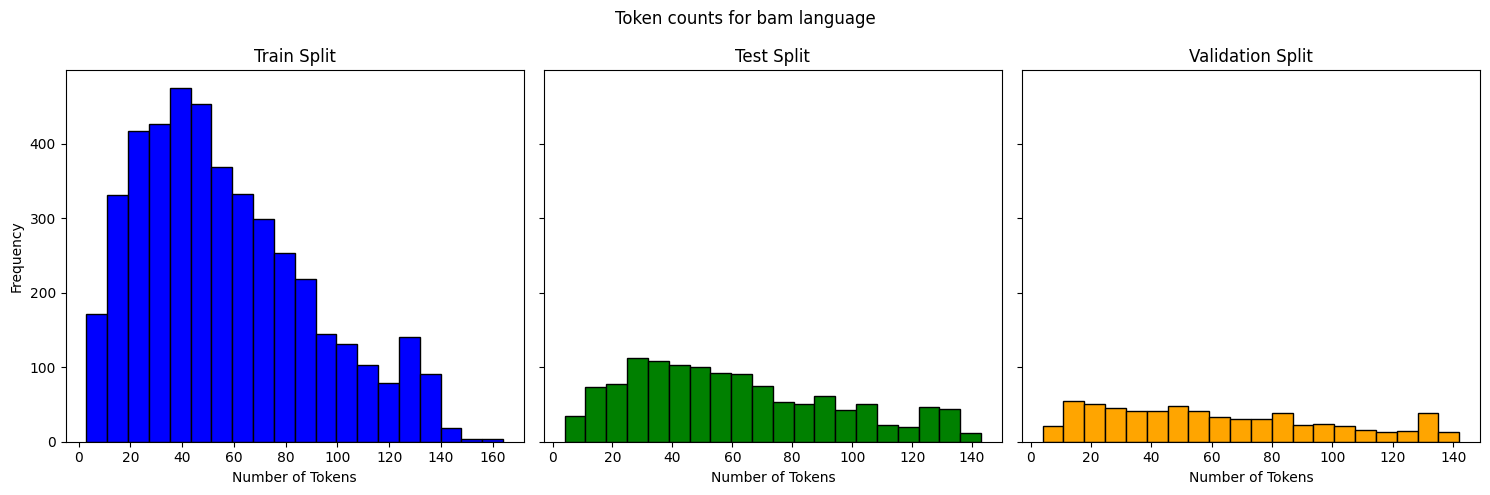

In [32]:
train_lengths = [len(record['input_ids']) for record in dataset['train']]
test_lengths = [len(record['input_ids']) for record in dataset['test']]
validation_lengths = [len(record['input_ids']) for record in dataset['validation']]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Plotting histograms for each split
axes[0].hist(train_lengths, bins=20, color='blue', edgecolor='black')
axes[0].set_title('Train Split')
axes[0].set_xlabel('Number of Tokens')
axes[0].set_ylabel('Frequency')

axes[1].hist(test_lengths, bins=20, color='green', edgecolor='black')
axes[1].set_title('Test Split')
axes[1].set_xlabel('Number of Tokens')

axes[2].hist(validation_lengths, bins=20, color='orange', edgecolor='black')
axes[2].set_title('Validation Split')
axes[2].set_xlabel('Number of Tokens')

plt.suptitle(f'Token counts for {LANGUAGE} language')
plt.tight_layout()
plt.show()

### PyTorch Dataset &  Dataloader

In [44]:
class TorchDataset(Dataset):
    """
    Converts Hugging Face dataset to PyTorch dataset.
    """
    def __init__(self, hf_dataset, max_length=None, padding_value=0):
        self.hf_dataset = hf_dataset
        self.max_length = max_length
        self.padding_value = padding_value

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        
        # Cropping or padding the items individually
        labels = torch.tensor(item['labels'])
        attention_mask = torch.tensor(item['attention_mask'])
        input_ids = torch.tensor(item['input_ids'])

        if self.max_length is not None:
            # Crop if the sequence is too long
            labels = labels[:self.max_length]
            attention_mask = attention_mask[:self.max_length]
            input_ids = input_ids[:self.max_length]

            # Padding if the sequence is too short
            labels_padded = torch.full((self.max_length,), self.padding_value, dtype=labels.dtype)
            attention_mask_padded = torch.full((self.max_length,), self.padding_value, dtype=attention_mask.dtype)
            input_ids_padded = torch.full((self.max_length,), self.padding_value, dtype=input_ids.dtype)

            labels_padded[:len(labels)] = labels
            attention_mask_padded[:len(attention_mask)] = attention_mask
            input_ids_padded[:len(input_ids)] = input_ids

            labels = labels_padded
            attention_mask = attention_mask_padded
            input_ids = input_ids_padded

        return {'labels': labels, 'attention_mask': attention_mask, 'input_ids': input_ids}



# Convert the datasets.Dataset to a PyTorch Dataset
pytorch_dataset_train = TorchDataset(dataset['train'],
                                     # Max number of tokens for Bambara language
                                     max_length=config['languages_max_tokens'][LANGUAGE],
                                     padding_value=config['tokenizer_settings']['padding_value'])

# Create a PyTorch DataLoader
dataloader_train = DataLoader(pytorch_dataset_train,
                              batch_size=config['train_settings']['batch_size'],
                              shuffle=config['train_settings']['shuffle'])

In [45]:
next(iter(dataloader_train))

{'labels': tensor([[-100,    0,    0,  ...,    0,    0,    0],
         [-100,    0,    0,  ...,    0,    0,    0],
         [-100,    0,    0,  ...,    0,    0,    0],
         ...,
         [-100,    0,    0,  ...,    0,    0,    0],
         [-100,    0,    0,  ...,    0,    0,    0],
         [-100,    0,    0,  ...,    0,    0,    0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'input_ids': tensor([[     0,   6755,  87166,  ...,      0,      0,      0],
         [     0,    803, 245963,  ...,      0,      0,      0],
         [     0,    180,    552,  ...,      0,      0,      0],
         ...,
         [     0,  25908,     14,  ...,      0,      0,      0],
         [     0,    786,   1234,  ...,      0,      0,      0],
         [     0,     62,    113,  ...,      0,      0,     

In [46]:
# Batch size * max sequence length
next(iter(dataloader_train))['input_ids'].shape

torch.Size([16, 164])